In [ ]:
!pip install patchify

In [2]:
import os
import re
import numpy as np
from pathlib import Path
from patchify import patchify
from PIL import Image

In [3]:
def create_folder():
  FOLDERS = ["train", "test", "val"]
  for folder in FOLDERS:
    if not os.path.exists(folder):
      folder_images = f"{folder}/images"
      folder_msks = f"{folder}/masks"
      os.makedirs(folder_images) if not os.path.exists(folder_images) else print("Folder already exists")
      os.makedirs(folder_msks) if not os.path.exists(folder_msks) else print("Folder already exists")

create_folder()

In [ ]:
!unzip "archive.zip" -d "data"

In [5]:
def create_patches(src, dest_path):
  path_split = os.path.split(src)
  tile_num = re.findall(r'\d',path_split[0])[0]
  image = Image.open(src)
  image = np.asarray(image)
  if len(image.shape) > 2:
    patches = patchify(image, (320,320,3),step = 300)
    filename_wo_ext = Path(src).stem
    for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
        patch = patches[i,j,0]
        patch = Image.fromarray(patch)
        num = i*patches.shape[1] + j
        patch.save(f"{dest_path}/{filename_wo_ext}_tile_{tile_num}_patch_{num}.png")


In [6]:
for pathname,_,filename in os.walk('data'):
  for f in filename:
    path_split = os.path.split(pathname)
    title_num = re.findall(r'\d+',path_split[0])[0]
    img_type = path_split[1]

    if title_num == '3':
      target_folder_imgs = 'val'
      target_folder_masks = 'val'
    elif title_num == '1':
      target_folder_imgs = 'test'
      target_folder_masks = 'test'
    else:
      target_folder_imgs = 'train'
      target_folder_masks = 'train'
    src = os.path.join(pathname, f)
    file_name_wo_ext = Path(src).stem
    img_file = f"{path_split[0]}/images/{file_name_wo_ext}.jpg"
    mask_file = f"{path_split[0]}/masks/{file_name_wo_ext}.png"

    if os.path.exists(img_file) and os.path.exists(mask_file):
      if img_type == "images":
        dest = os.path.join(target_folder_imgs, img_type)
        create_patches(src,dest)

      if img_type == "masks":
        dest = os.path.join(target_folder_masks, img_type)
        create_patches(src,dest)


In [7]:
from torch.utils.data import Dataset
import os
from pathlib import Path
import cv2

In [8]:
class SegmentationDataset(Dataset):
  def __init__(self,path_name):
    super().__init__()
    self.image_names = os.listdir(f"{path_name}/images")
    self.image_paths = [f"{path_name}/images/{i}" for i in self.image_names]
    self.mask_names = os.listdir(f"{path_name}/masks")
    self.mask_paths = [f"{path_name}/masks/{i}" for i in self.mask_names]

    self.img_stem = [Path(i).stem for i in self.image_paths]
    self.mask_stem = [Path(i).stem for i in self.mask_paths]
    self.img_mask_stem = set(self.img_stem) & set(self.mask_stem)
    self.image_paths = [i for i in self.image_paths if (Path(i).stem in self.img_mask_stem)]


  def __len__(self):
    return len(self.img_mask_stem)

  def convert_mask(self, mask):
    mask[mask == 155] = 0
    mask[mask == 44] = 1 #building
    mask[mask == 91] = 2 #land
    mask[mask == 171] = 3 #water
    mask[mask == 172] = 4 #road
    mask[mask == 212] = 5 #vegetation
    return mask

  def __getitem__(self,index):
    image = cv2.imread(self.image_paths[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.transpose((2,0,1))
    mask = cv2.imread(self.mask_paths[index], 0)
    mask = self.convert_mask(mask)
    return image, mask


In [ ]:
!pip install segmentation-models-pytorch


In [10]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import seaborn as sns
import matplotlib.pyplot as plt


In [11]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
BS = 4

In [12]:
train_ds = SegmentationDataset(path_name = 'train')
train_dataloader = DataLoader(train_ds, batch_size = BS, shuffle = True)
val_ds = SegmentationDataset(path_name = 'val')
val_dataloader = DataLoader(val_ds, batch_size = BS, shuffle = True)
test_ds = SegmentationDataset(path_name = 'test')
test_dataloader = DataLoader(test_ds, batch_size = BS, shuffle = True)


In [ ]:
model = smp.FPN(classes = 6, activation = 'sigmoid')
model.to(DEVICE)

In [14]:
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr = .001)])


In [15]:
criterion = nn.CrossEntropyLoss()

In [17]:
train_losses, val_losses = [], []

for e in range(EPOCHS):
  model.train()
  running_train_loss, running_val_loss = 0, 0
  for i, data in enumerate(train_dataloader):
    image_i, mask_i = data
    image = image_i.to(DEVICE)
    mask = mask_i.to(DEVICE)

    optimizer.zero_grad()

    output = model(image.float())

    train_loss = criterion(output.float(), mask.long())

    train_loss.backward()
    optimizer.step()

    running_train_loss+=train_loss.item()
  train_losses.append(running_train_loss)

  model.eval()
  with torch.no_grad():
    for i, data in enumerate(val_dataloader):
      image_i, mask_i = data
      image = image_i.to(DEVICE)
      mask = mask_i.to(DEVICE)

      output = model(image.float())

      val_loss = criterion(output.float(), mask.long())


      running_val_loss+=val_loss.item()
  val_losses.append(running_val_loss)
  print(f"Epoch {e}, Train Loss : {running_train_loss}, Val Loss : {running_val_loss}")


Epoch 0, Train Loss : 211.39267814159393, Val Loss : 11.901309728622437
Epoch 1, Train Loss : 205.08286094665527, Val Loss : 11.351155996322632
Epoch 2, Train Loss : 200.44258189201355, Val Loss : 10.838818311691284
Epoch 3, Train Loss : 196.61917400360107, Val Loss : 10.889389276504517
Epoch 4, Train Loss : 195.78015899658203, Val Loss : 10.748542428016663
Epoch 5, Train Loss : 193.88729333877563, Val Loss : 10.804116487503052
Epoch 6, Train Loss : 193.93692767620087, Val Loss : 10.976284742355347
Epoch 7, Train Loss : 192.09586763381958, Val Loss : 10.698649525642395
Epoch 8, Train Loss : 191.50105047225952, Val Loss : 10.673535943031311
Epoch 9, Train Loss : 190.45634961128235, Val Loss : 10.69126558303833
Epoch 10, Train Loss : 188.92988276481628, Val Loss : 10.652472853660583
Epoch 11, Train Loss : 190.56357526779175, Val Loss : 10.636879801750183
Epoch 12, Train Loss : 190.08404195308685, Val Loss : 10.794927477836609
Epoch 13, Train Loss : 188.85761988162994, Val Loss : 10.67239

Text(0.5, 1.0, 'Train Loss')

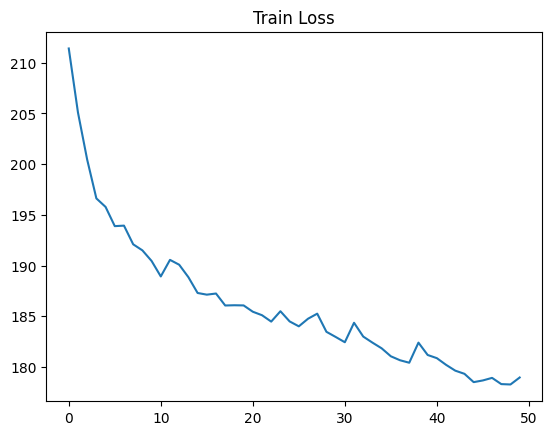

In [20]:
sns.lineplot(x=range(len(train_losses)), y=train_losses).set_title('Train Loss')


Text(0.5, 1.0, 'Val Loss')

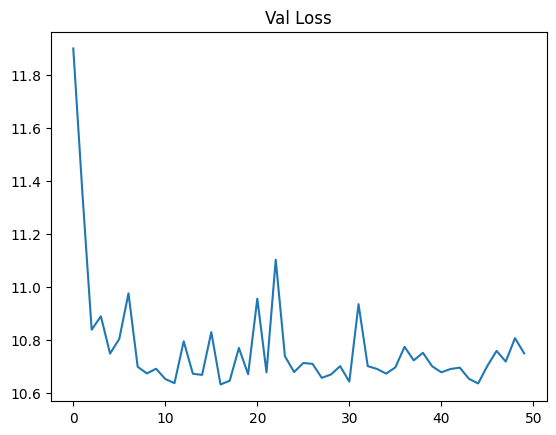

In [21]:
sns.lineplot(x = range(len(val_losses)), y = val_losses).set_title('Val Loss')

In [19]:
torch.save(model.state_dict(), "model_50.pth")

In [23]:
!pip install torchmetrics

In [24]:
import torchmetrics

In [37]:
pixel_accuracies = []
intersection_over_unions = []
metric_iou = torchmetrics.JaccardIndex(num_classes = 6, task = 'multiclass').to(DEVICE)

In [38]:
with torch.no_grad():
  for data in test_dataloader:
    inputs,outputs = data
    true = outputs.to(torch.float32)
    pred = model(inputs.to(DEVICE).float())
    predicted_class = torch.max(pred, 1)[1]
    true = true.to(DEVICE)

    correct_pixels = (true == predicted_class).sum().item()
    total_pixels = true.size(1)*true.size(2)*true.size(0)

    pixel_accuracies.append(correct_pixels/total_pixels)
    iou = metric_iou(predicted_class.float(), true).item()
    intersection_over_unions.append(iou)


In [39]:
print(f"Median Pixel Accuracy: {np.median(pixel_accuracies) * 100}")

Median Pixel Accuracy: 84.5830078125


In [40]:
print(f"Median  IOU: {np.median(intersection_over_unions) * 100}")

Median  IOU: 40.148064494132996


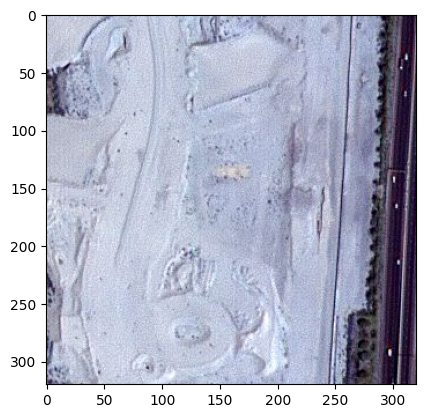

In [66]:
image_test, mask = next(iter(test_dataloader))

plt.imshow(np.transpose(image_test[0,:,:,:].cpu().numpy(), (1,2,0)))

Text(0.5, 1.0, 'Predicted Mask')

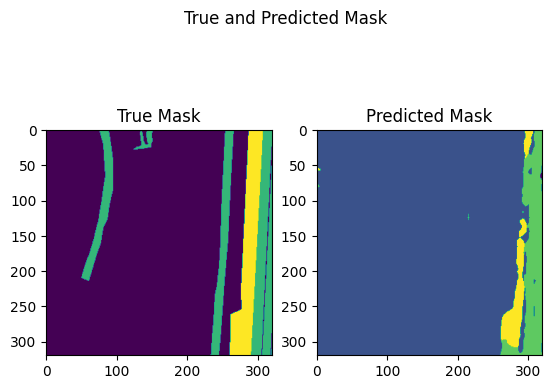

In [67]:
with torch.no_grad():
  image_test = image_test.float().to(DEVICE)
  output = model(image_test)[0,:,:,:]

output_cpu = output.cpu().squeeze().numpy()

output_cpu = output_cpu.transpose((1,2,0))
output_cpu = output_cpu.argmax(axis = 2)
fig, axs = plt.subplots(nrows = 1, ncols = 2)

fig.suptitle("True and Predicted Mask")
axs[0].imshow(mask[0,:,:])
axs[1].imshow(output_cpu)

axs[0].set_title("True Mask")
axs[1].set_title("Predicted Mask")